# AMOC variability in FOCI-OpenIFS

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.signal import welch

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44869 instead
  expected, actual


In [4]:
client

Client Scheduler: tcp://127.0.0.1:37169 Dashboard: http://127.0.0.1:44869/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [5]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

## Read NEMO mesh

In [6]:
# NEMO mesh
ds_mesh = xr.open_dataset(nemo_mesh)
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)

## Read NEMO stream functions

In [7]:
exp_list = ['FOCI_GJK001']

In [8]:
# NEMO derived
ds_moc_all = []
ds_psi_all = []
for exp in exp_list:
    moc = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*MOC.nc' % (esmdir,exp,exp)
    print(moc)
    ds_moc = xr.open_mfdataset(moc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'})
    ds_moc_all.append(ds_moc)
    
    psi = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*PSI.nc' % (esmdir,exp,exp)
    print(psi)
    ds_psi = xr.open_mfdataset(psi,combine='by_coords',use_cftime=True).rename({'time_counter':'time'})
    ds_psi_all.append(ds_psi)

//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*MOC.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*PSI.nc


## Time-mean overturning

<xarray.Dataset>
Dimensions:    (depthw: 46, time: 12360, x: 1, y: 511)
Coordinates:
  * depthw     (depthw) float32 -0.0 -6.194 -12.84 ... -5.5e+03 -5.75e+03
  * time       (time) object 1850-01-16 12:00:00 ... 2879-12-16 12:00:00
Dimensions without coordinates: x, y
Data variables:
    nav_lon    (time, y, x) float32 dask.array<chunksize=(120, 511, 1), meta=np.ndarray>
    nav_lat    (time, y, x) float32 dask.array<chunksize=(120, 511, 1), meta=np.ndarray>
    zomsfglo   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfatl   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfinp   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfind   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfpac   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfinp0  (time, depthw, y,

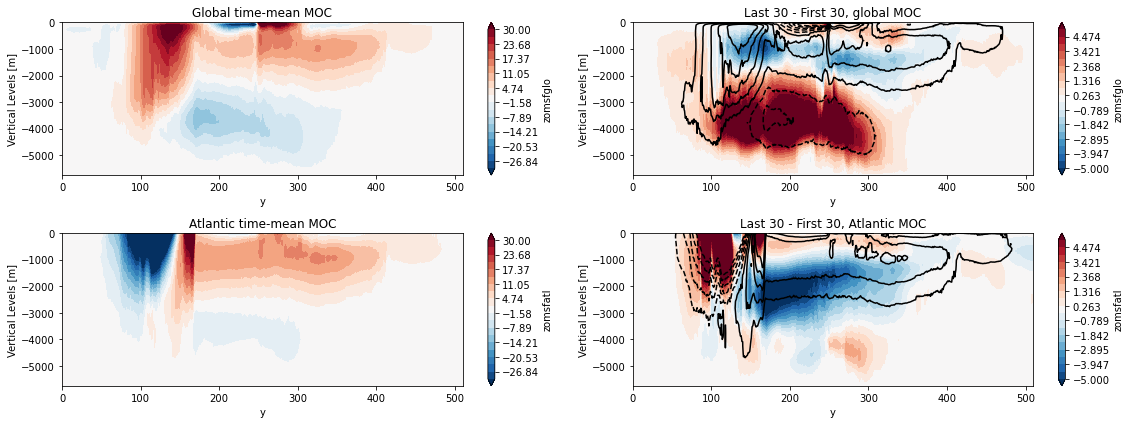

In [9]:
fig, ax = plt.subplots(2,2,figsize=(16,6))

mlevels = np.linspace(-30,30,20)
mlevels2 = np.linspace(-5,5,20)

for i in range(0,len(exp_list)):
    ds_moc = ds_moc_all[i]
    print(ds_moc)
    
    glo = ds_moc['zomsfglo'].sel(x=0)
    atl = ds_moc['zomsfatl'].sel(x=0)
    
    glo_mean = glo.mean('time')
    atl_mean = atl.mean('time')
    
    # Compare first and last 30 years
    glo_diff = glo[-360:,:,:].mean('time') - glo[0:360,:,:].mean('time')
    atl_diff = atl[-360:,:,:].mean('time') - atl[0:360,:,:].mean('time')
    
    glo_mean.plot.contourf(ax=ax[0,0],levels=mlevels)
    glo_mean.plot.contour(ax=ax[0,1],levels=mlevels[::2],colors='k')
    glo_diff.plot.contourf(ax=ax[0,1],levels=mlevels2)
    ax[0,0].set_title('Global time-mean MOC')
    ax[0,1].set_title('Last 30 - First 30, global MOC')
    
    atl_mean.plot.contourf(ax=ax[1,0],levels=mlevels)
    atl_mean.plot.contour(ax=ax[1,1],levels=mlevels[::2],colors='k')
    atl_diff.plot.contourf(ax=ax[1,1],levels=mlevels2)
    ax[1,0].set_title('Atlantic time-mean MOC')
    ax[1,1].set_title('Last 30 - First 30, Atlantic MOC')

fig.tight_layout()
fig.savefig('moc.jpg',format='jpg',dpi=600)

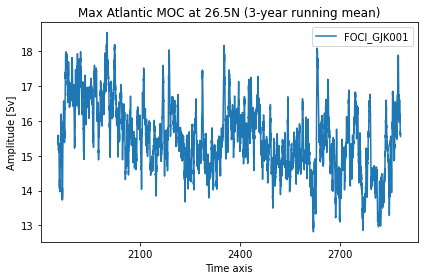

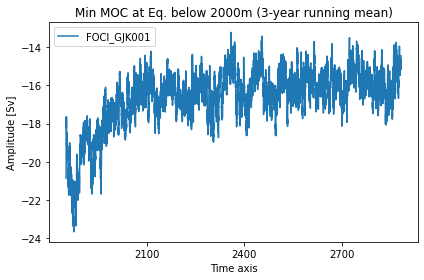

In [10]:
fig1, ax1 = plt.subplots(1,1)
fig2, ax2 = plt.subplots(1,1)

for i in range(0,len(exp_list)):
    exp = exp_list[i]
    ds_moc = ds_moc_all[i]
    
    # Max stream function at y=304 (26.5 N)
    amoc = ds_moc['zomsfatl'].sel(x=0,y=304).max('depthw').compute()
    amoc.rolling(time=36).mean().plot(ax=ax1,label=exp)
    
    # Min stream function at y=250 (approx equator) below 2000
    aabw = ds_moc['zomsfglo'][:,29:,:,:].sel(x=0,y=250).min('depthw').compute()
    aabw.rolling(time=36).mean().plot(ax=ax2,label=exp)
    
ax1.set_title('Max Atlantic MOC at 26.5N (3-year running mean)')
ax1.set_ylabel('Amplitude [Sv]')
ax1.legend()
fig1.tight_layout()
fig1.savefig('moc_timeseries.png',format='png')

ax2.set_title('Min MOC at Eq. below 2000m (3-year running mean)')
ax2.set_ylabel('Amplitude [Sv]')
ax2.legend()
fig2.tight_layout()
fig2.savefig('aabw_timeseries.png',format='png')

## Power spectrum of AMOC

In [31]:
def powerspectrum(x, fs=1):
    # sample size
    N = x.size
    
    # bandwidth
    df = fs / N
    
    # frequency of the signal [cycle-per-time-unit]
    f_0 = 1. / 1.
    
    # length of time series
    t1 = N / fs
    
    # length of sample in cycles
    n_cycle = N / fs * f_0
    
    t = np.linspace(0., t1, N)
    freq = np.fft.rfftfreq(N,1./fs)
    
    #omega_nino = 2 * np.pi * freq
    f_transform = np.fft.rfft(x)   # [units]
    amp = np.abs(f_transform) / N  # [units]
    Phi = amp ** 2                 # [units**2]
    PSD = Phi / df                 # [units**2 / fs time]
    
    return freq,PSD

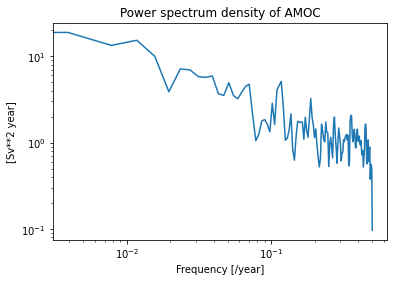

In [40]:
#x = amoc.rolling(time=36).mean().dropna('time').values
x = amoc.groupby('time.year').mean('time').values
#freq, PSD = powerspectrum(x,fs=1)

# Use Welch method to reduce noise
freq, PSD = welch(x,fs=1)

fig1, ax1 = plt.subplots(1,1)
ax1.loglog(freq,PSD)
ax1.set_xlabel('Frequency [/year]');
ax1.set_ylabel('[Sv**2 year]');
ax1.set_title('Power spectrum density of AMOC');
#ax1.set_ylim([1e-3,1e3])
fig1.savefig('Fig4_AMOC_PSD.pdf',format='pdf')

In [41]:
## Make one plot for AMOC and ACC

 Compute AMOC strf


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/plot.py:975: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contourf(x, y, z, **kwargs)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/plot.py:964: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contour(x, y, z, **kwargs)


 Compute AMOC time series 
 Compute baro psi 


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/plot.py:975: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contourf(x, y, z, **kwargs)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/plot.py:964: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contour(x, y, z, **kwargs)


 Compute Drake Pass 


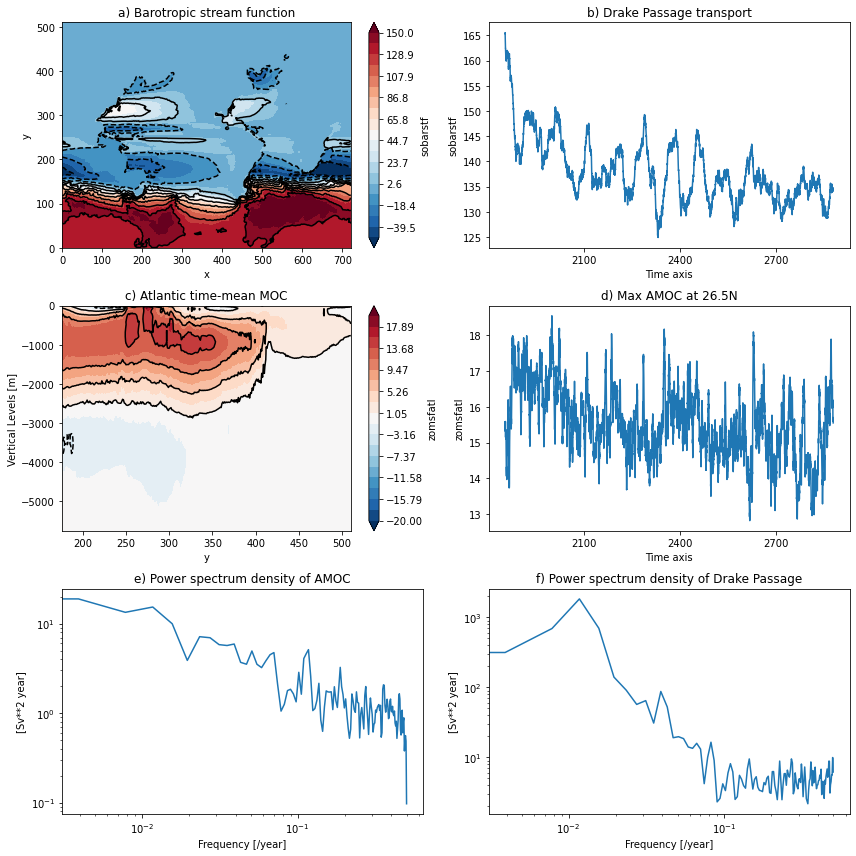

In [49]:
fig, ax = plt.subplots(3,2,figsize=(12,12))

for i, (ds_moc,ds_psi) in enumerate( zip(ds_moc_all, ds_psi_all) ):
    
    atl = ds_moc['zomsfatl'].sel(x=0)
    print(' Compute AMOC strf')
    atl_mean = atl.mean('time').compute()
    
    mlevels = np.linspace(-20,20,20)
    atl_mean.plot.contourf(ax=ax[1,0],levels=mlevels, rasterized=True)
    atl_mean.plot.contour(ax=ax[1,0],levels=mlevels[::2],colors='k', rasterized=True)
    ax[1,0].set_title('c) Atlantic time-mean MOC')
    ax[1,0].set_xlim([176,510])
    
    # Max stream function at y=304 (26.5 N)
    print(' Compute AMOC time series ')
    amoc = ds_moc['zomsfatl'].sel(x=0,y=304).max('depthw').compute()
    amoc.rolling(time=36).mean().plot(ax=ax[1,1],label=exp)
    ax[1,1].set_title('d) Max AMOC at 26.5N')
    
    x = amoc.groupby('time.year').mean('time').values
    freq, PSD = welch(x,fs=1)
    ax[2,0].loglog(freq,PSD)
    ax[2,0].set_xlabel('Frequency [/year]');
    ax[2,0].set_ylabel('[Sv**2 year]');
    ax[2,0].set_title('e) Power spectrum density of AMOC');
    
    # Take barotropic stream function
    psi = ds_psi['sobarstf'] * 1e-6
    print(' Compute baro psi ')
    psi_mean = psi.mean('time').compute()
    
    mlevels = np.linspace(-50,150,20)
    psi_mean.plot.contourf(ax=ax[0,0],levels=mlevels, rasterized=True)
    psi_mean.plot.contour(ax=ax[0,0],levels=mlevels[::2],colors='k', rasterized=True)
    ax[0,0].set_title('a) Barotropic stream function')
    
    # Drake Passage
    print(' Compute Drake Pass ')
    drake = (psi.sel(x=436,y=51) - psi.sel(x=436,y=119)).compute()
    drake.rolling(time=36).mean().plot(ax=ax[0,1],label=exp)
    ax[0,1].set_title('b) Drake Passage transport')
    
    x = drake.groupby('time.year').mean('time').values
    freq, PSD = welch(x,fs=1)
    ax[2,1].loglog(freq,PSD)
    ax[2,1].set_xlabel('Frequency [/year]');
    ax[2,1].set_ylabel('[Sv**2 year]');
    ax[2,1].set_title('f) Power spectrum density of Drake Passage');
    
fig.tight_layout()
fig.savefig('Fig5_strf.pdf',format='pdf')